<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch02_CH02_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:

import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from glob import glob
import os

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras

In [18]:
LABEL_INT_DICT = np.unique(pd.read_csv('/content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_train_vid.csv')['label'])
LABEL_STR_DICT = { k:v for v, k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_INT_DICT)
pprint(LABEL_STR_DICT)

array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)
{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [19]:
MAX_FRAME = 10 # 몇개의 frame feature들이 한번에 들어오는지
NUM_FEATURES = 1280 # feature dimension

def build_model():
    inputs = keras.Input((MAX_FRAME, NUM_FEATURES))
    x = keras.layers.LSTM(64, return_sequences = True)(inputs) # 모든 시퀀스 반환
    x = keras.layers.LSTM(64, return_sequences = False)(x) # 마지막 시퀀스만 반환
    x = keras.layers.Dropout(0.3)(x)
    output = keras.layers.Dense(len(LABEL_INT_DICT), activation = 'softmax')(x)

    model = keras.Model(inputs, output)
    return model

adam = keras.optimizers.Adam(learning_rate = 0.0001)
model = build_model()

model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 1280)]        0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 64)            344320    
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 378059 (1.44 MB)
Trainable params: 378059 (1.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
import albumentations as A
import math
import tensorflow as tf
from tensorflow import keras


class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, mode ='train', shuffle =True):
        assert mode in ['train', 'valid']

        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size

        self.npy_paths = glob(
            f'/content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/UCF11_updated_numpy/{mode}/*.npy'
        )
    def __len__(self):
        return math.ceil(len(self.npy_paths)/ self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.npy_paths[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x = []
        batch_y = []

        for npy_path in data:
            npy = np.load(npy_path)

            label = npy_path.split('/')[-1].split('_')[0]
            label = LABEL_STR_DICT[label]

            batch_x.append(npy)
            batch_y.append(label)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle :
            random.shuffle(self.npy_paths)

train_generator = DataGenerator(
    mode = 'train',
    batch_size = 128,
    shuffle = True
)
valid_generator = DataGenerator(
    mode = 'valid',
    batch_size = 128,
    shuffle = True
)

In [21]:
for X, y in train_generator:
    print(X.shape)
    print(y.shape)
    break

(128, 10, 1280)
(128,)


In [22]:
history = model.fit(
    train_generator,
    validation_data= valid_generator,
    epochs = 30,
    verbose = 1,
)


Epoch 1/30
2/2 [==============================] - 6s 1s/step - loss: 2.4524 - accuracy: 0.0818 - val_loss: 2.3907 - val_accuracy: 0.1273
Epoch 2/30
2/2 [==============================] - 1s 384ms/step - loss: 2.3828 - accuracy: 0.1727 - val_loss: 2.3551 - val_accuracy: 0.2364
Epoch 3/30
2/2 [==============================] - 1s 301ms/step - loss: 2.3372 - accuracy: 0.2318 - val_loss: 2.3185 - val_accuracy: 0.3273
Epoch 4/30
2/2 [==============================] - 1s 348ms/step - loss: 2.2657 - accuracy: 0.3045 - val_loss: 2.2819 - val_accuracy: 0.3818
Epoch 5/30
2/2 [==============================] - 1s 322ms/step - loss: 2.1783 - accuracy: 0.4045 - val_loss: 2.2454 - val_accuracy: 0.4364
Epoch 6/30
2/2 [==============================] - 1s 573ms/step - loss: 2.1553 - accuracy: 0.5000 - val_loss: 2.2091 - val_accuracy: 0.4909
Epoch 7/30
2/2 [==============================] - 1s 716ms/step - loss: 2.0802 - accuracy: 0.5318 - val_loss: 2.1732 - val_accuracy: 0.4909
Epoch 8/30
2/2 [=======

<function matplotlib.pyplot.show(close=None, block=None)>

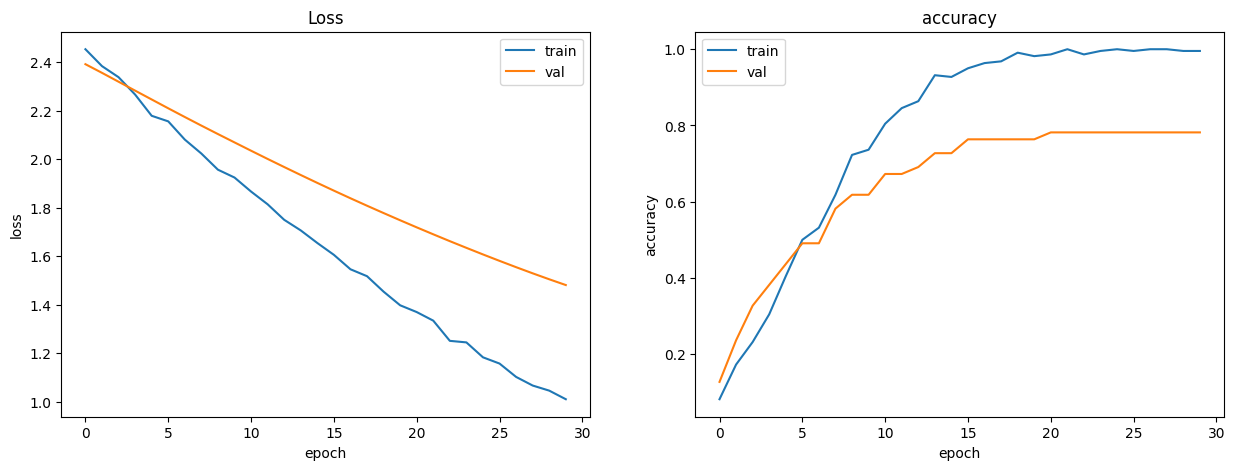

In [23]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label ='train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label ='train')
plt.plot(history['val_accuracy'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.show
